In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/TactileDriven_Arto/UTILITIES')
from PreProcessingFunctions import WS, WS_B

from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt
import traceback

import tensorflow
import tensorflow as tf
gpus = tensorflow.config.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
# Set GPU 1 (the second GPU) to be the only visible device
if gpus:
    try:
        tf.config.set_visible_devices(gpus[1], 'GPU')
        
        # Optionally, set memory growth to avoid allocating all memory on the GPU at once
        tf.config.experimental.set_memory_growth(gpus[1], True)
    except RuntimeError as e:
        print(e)


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data


data_folder = '/home/rl_sim/TactileDriven_Arto/ML_Buttons/DATA/1D_TRANSF_FTP_NotNorm'

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

WS_B = 800  # Example sequence length
input_shape = (WS_B, 1)

X_train_list = []
X_val_list = []
X_test_list = []

# Extract and append the data to the lists
for i in range(6):
    X_train_list.append(X_train[:,:,i])
    X_val_list.append(X_val[:,:,i])
    X_test_list.append(X_test[:,:,i])

# If you need the variables explicitly named, you can unpack them from the lists
X_train1, X_train2, X_train3, X_train4, X_train5, X_train6 = X_train_list
X_val1, X_val2, X_val3, X_val4, X_val5, X_val6 = X_val_list
X_test1, X_test2, X_test3, X_test4, X_test5, X_test6 = X_test_list

print("Shapes in X_train_list:")
for i, array in enumerate(X_train_list):
    print(f"X_train{i+1}.shape: {array.shape}")

OUT_N = int(np.max(y_data))  # Plus one because labels are typically zero-indexed
DISP_LABELS = list(range(OUT_N+1))  # Generate labels from 0 to OUT_N+1
print("OUT_N:", OUT_N)
print("DISP_LABELS:", DISP_LABELS)


2024-07-11 11:46:42.465431: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-11 11:46:42.491664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 11:46:42.980385: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-11 11:46:43.337285: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more 

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
X_data shape: (1465, 800, 9)
y_data shape: (1465,)
X_data.[0] shape:  (800, 9)
TOTAL DATA: 1465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (879, 800, 9)    ||  Dimensions of y_train: (879,)
Dimensions of X_test:  (293, 800, 9)    ||  Dimensions of y_test:  (293,)
Dimensions of X_val:   (293, 800, 9)    ||  Dimensions of y_val:   (293,)
Shapes in X_train_list:
X_train1.shape: (879, 800)
X_train2.shape: (879, 800)
X_train3.shape: (879, 800)
X_train4.shape: (879, 800)
X_train5.shape: (879, 800)
X_train6.shape: (879, 800)
OUT_N: 1
DISP_LABELS: [0, 1]


Epoch 1/90


2024-07-11 11:46:43.632724: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 11:46:43.632933: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 11:46:43.633057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

20/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4959 - loss: 0.7074 

I0000 00:00:1720691211.075619 2527320 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - accuracy: 0.5293 - loss: 0.6864 - val_accuracy: 0.7304 - val_loss: 0.6421
Epoch 2/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7918 - loss: 0.5097 - val_accuracy: 0.7406 - val_loss: 0.4983
Epoch 3/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7443 - loss: 0.4996 - val_accuracy: 0.7679 - val_loss: 0.4698
Epoch 4/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8168 - loss: 0.3831 - val_accuracy: 0.7747 - val_loss: 0.4095
Epoch 5/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8210 - loss: 0.3672 - val_accuracy: 0.8532 - val_loss: 0.3535
Epoch 6/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8448 - loss: 0.3253 - val_accuracy: 0.8874 - val_loss: 0.3119
Epoch 7/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8609 - loss: 0.3014 - val_accuracy: 0.8737 - val_loss: 0.3026
Epoch 8/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8651 - loss: 0.2838 - val_accuracy: 0.7986 - val_loss: 0.3959


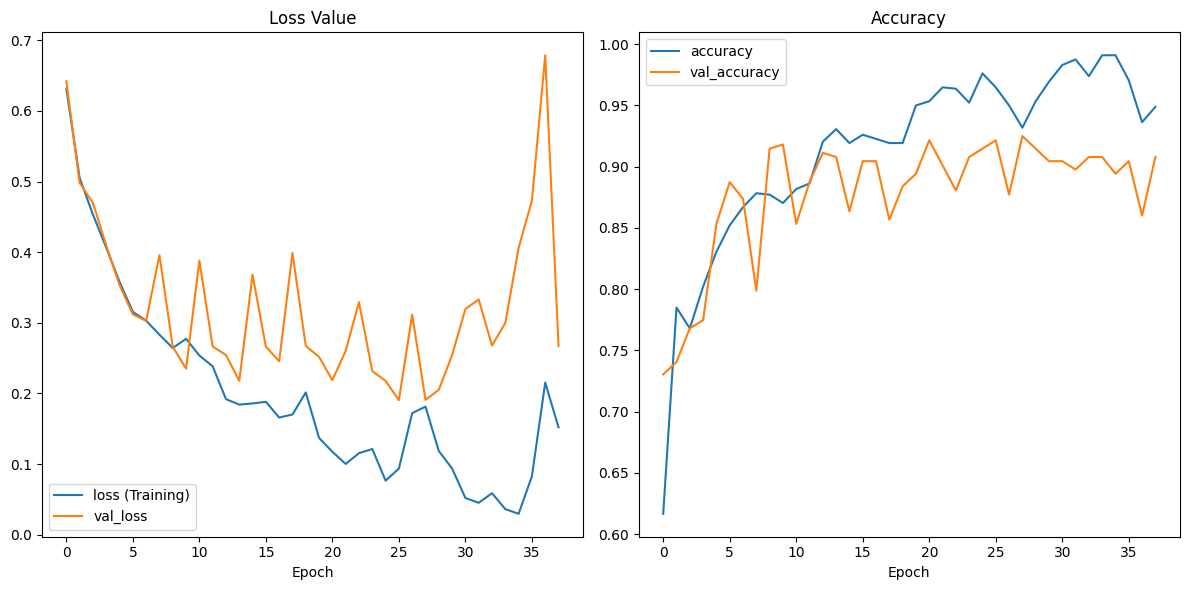

Test loss: 0.14852721989154816
Test accuracy: 0.9453924914675768
F1 Score: 0.9450539146741679
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       137
         1.0       0.94      0.96      0.95       156

    accuracy                           0.95       293
   macro avg       0.95      0.94      0.95       293
weighted avg       0.95      0.95      0.95       293



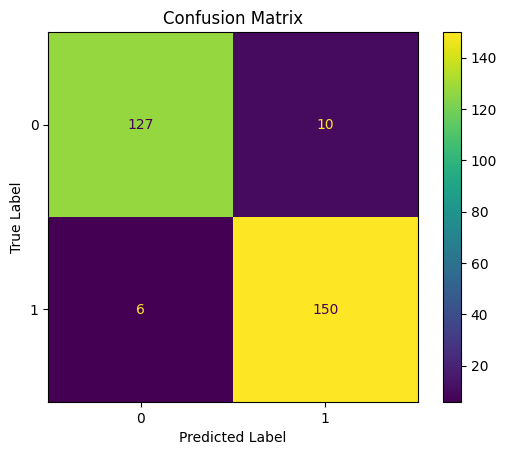

In [2]:
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', padding='same', name=f'conv1d_{branch_id}_0')(input_layer)
        x = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name=f'conv1d_{branch_id}_1')(x)
        x = Conv1D(filters=256, kernel_size=4, strides=2, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        x = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='sigmoid', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [(WS_B, 1), (WS_B, 1), (WS_B, 1), (WS_B, 1), (WS_B, 1), (WS_B, 1)]
model = build_branched_model(input_shapes)
#model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
history = model.fit(
    [X_train1, X_train2, X_train3, X_train4, X_train5, X_train6], 
    y_train, 
    epochs=90, 
    batch_size=32, 
    validation_data=([X_val1, X_val2, X_val3, X_val4, X_val5, X_val6], y_val), 
    verbose=1, 
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate([X_test1, X_test2, X_test3, X_test4, X_test5, X_test6], y_test)

# Predict labels for test data
y_pred = model.predict([X_test1, X_test2, X_test3, X_test4, X_test5, X_test6])
y_pred_labels = (y_pred > 0.5).astype(int)

# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()

# Calculate F1 score and accuracy
f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("F1 Score:", f1)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [3]:
# model_name = "ALL_KNOB_6Branches_%"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

Epoch 1/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5996 - loss: 0.6607 - val_accuracy: 0.6997 - val_loss: 0.5789
Epoch 2/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7429 - loss: 0.4879 - val_accuracy: 0.7713 - val_loss: 0.5055
Epoch 3/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7940 - loss: 0.4060 - val_accuracy: 0.7884 - val_loss: 0.4160
Epoch 4/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8015 - loss: 0.3787 - val_accuracy: 0.8020 - val_loss: 0.4200
Epoch 5/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8087 - loss: 0.3652 - val_accuracy: 0.8123 - val_loss: 0.3558
Epoch 6/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8460 - loss: 0.3062 - val_accuracy: 0.8259 - val_loss: 0.3562
Epoch 7/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8658 - loss: 0.3019 - val_accuracy: 0.8669 - val_loss: 0.2952
Epoch 8/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9032 - loss: 0.2408 - val_accuracy: 0.9010 - val_loss

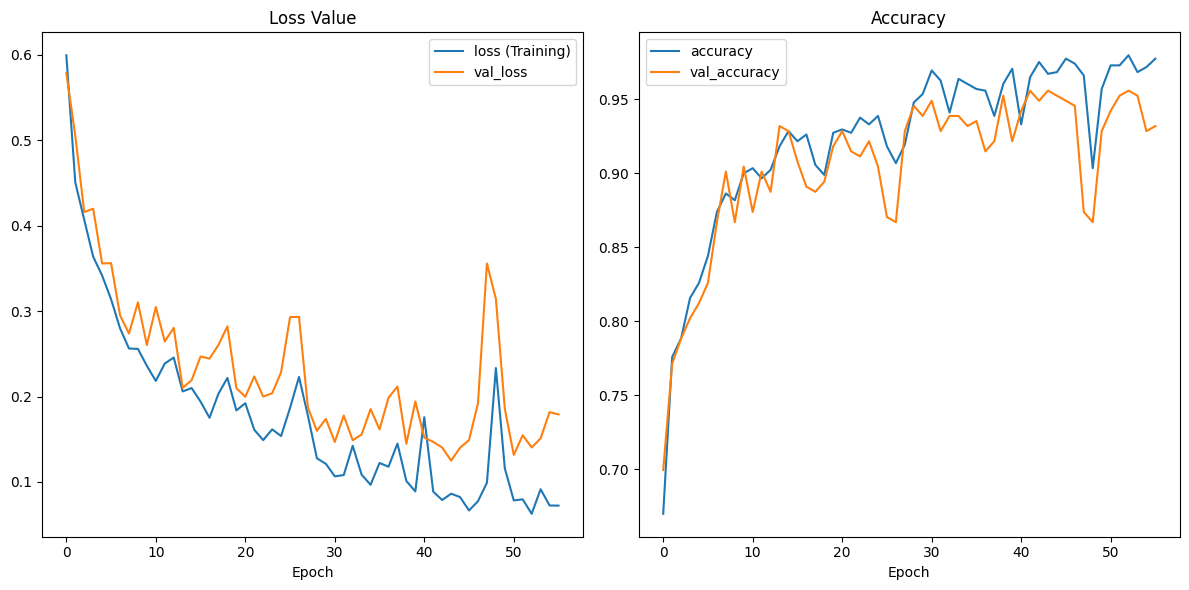

Test loss: 0.17826059460639954
Test accuracy: 0.9488054607508533
F1 Score: 0.948719444606499
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.97      0.95       137
         1.0       0.97      0.93      0.95       156

    accuracy                           0.95       293
   macro avg       0.95      0.95      0.95       293
weighted avg       0.95      0.95      0.95       293



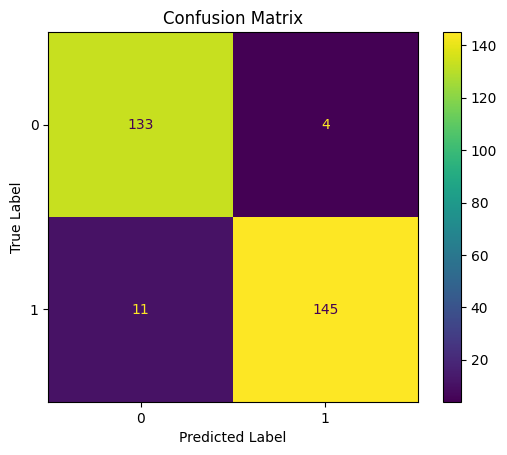

In [4]:
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=256, kernel_size=100, strides=20, activation='relu', padding='same', name=f'conv1d_{branch_id}_0')(input_layer)
        #x = Conv1D(filters=128, kernel_size=4, strides=2, activation='relu', name=f'conv1d_{branch_id}_1')(x)
        #x = Conv1D(filters=256, kernel_size=4, strides=2, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        # x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        # x = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='sigmoid', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [(WS_B, 1), (WS_B, 1), (WS_B, 1), (WS_B, 1), (WS_B, 1), (WS_B, 1)]
model = build_branched_model(input_shapes)
#model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
history = model.fit(
    [X_train1, X_train2, X_train3, X_train4, X_train5, X_train6], 
    y_train, 
    epochs=90, 
    batch_size=32, 
    validation_data=([X_val1, X_val2, X_val3, X_val4, X_val5, X_val6], y_val), 
    verbose=1, 
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate([X_test1, X_test2, X_test3, X_test4, X_test5, X_test6], y_test)

# Predict labels for test data
y_pred = model.predict([X_test1, X_test2, X_test3, X_test4, X_test5, X_test6])
y_pred_labels = (y_pred > 0.5).astype(int)

# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()

# Calculate F1 score and accuracy
f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("F1 Score:", f1)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.6034 - loss: 0.6789 - val_accuracy: 0.7611 - val_loss: 0.4751
Epoch 2/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8009 - loss: 0.4285 - val_accuracy: 0.7474 - val_loss: 0.5579
Epoch 3/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8051 - loss: 0.4310 - val_accuracy: 0.6348 - val_loss: 0.7316
Epoch 4/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8304 - loss: 0.3628 - val_accuracy: 0.8123 - val_loss: 0.4016
Epoch 5/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8699 - loss: 0.3182 - val_accuracy: 0.7884 - val_loss: 0.4256
Epoch 6/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8619 - loss: 0.3120 - val_accuracy: 0.8430 - val_loss: 0.3649
Epoch 7/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8596 - loss: 0.3117 - val_accuracy: 0.8259 - val_loss: 0.3916
Epoch 8/90
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8524 - loss: 0.3308 - val_accuracy: 0.8362 - val_lo

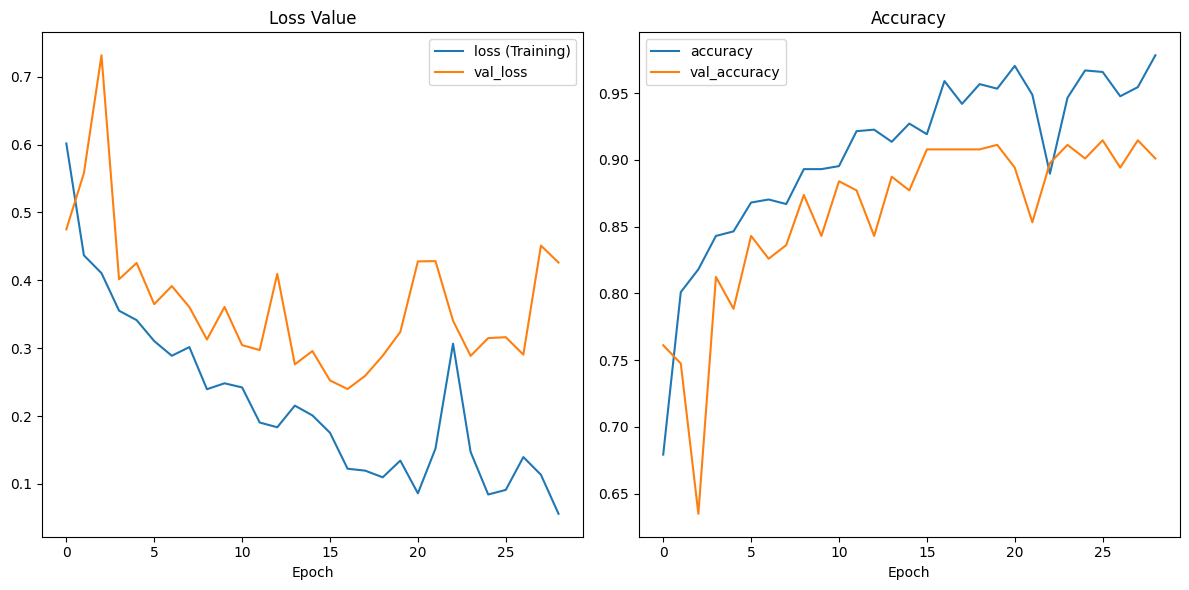

Test loss: 0.2703845202922821
Test accuracy: 0.9215017064846417
F1 Score: 0.9214870737362086
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.97      0.92       137
         1.0       0.97      0.88      0.92       156

    accuracy                           0.92       293
   macro avg       0.92      0.92      0.92       293
weighted avg       0.93      0.92      0.92       293



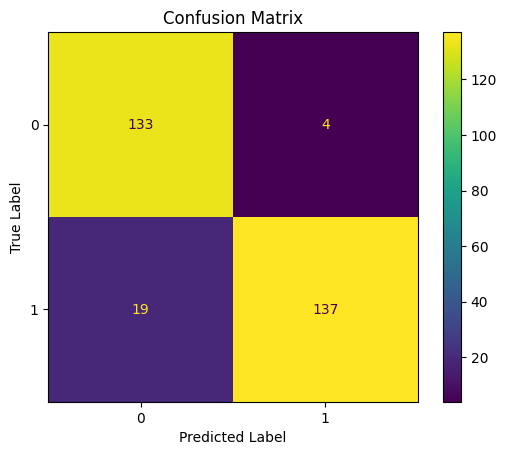

In [5]:
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=256, kernel_size=100, strides=20, activation='relu', padding='same', name=f'conv1d_{branch_id}_0')(input_layer)
        x = Conv1D(filters=128, kernel_size=10, strides=4, activation='relu', name=f'conv1d_{branch_id}_1')(x)
        x = Conv1D(filters=256, kernel_size=4, strides=2, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        x = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(128, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='sigmoid', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [(WS_B, 1), (WS_B, 1), (WS_B, 1), (WS_B, 1), (WS_B, 1), (WS_B, 1)]
model = build_branched_model(input_shapes)
#model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
history = model.fit(
    [X_train1, X_train2, X_train3, X_train4, X_train5, X_train6], 
    y_train, 
    epochs=90, 
    batch_size=32, 
    validation_data=([X_val1, X_val2, X_val3, X_val4, X_val5, X_val6], y_val), 
    verbose=1, 
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate([X_test1, X_test2, X_test3, X_test4, X_test5, X_test6], y_test)

# Predict labels for test data
y_pred = model.predict([X_test1, X_test2, X_test3, X_test4, X_test5, X_test6])
y_pred_labels = (y_pred > 0.5).astype(int)

# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()

# Calculate F1 score and accuracy
f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("F1 Score:", f1)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()